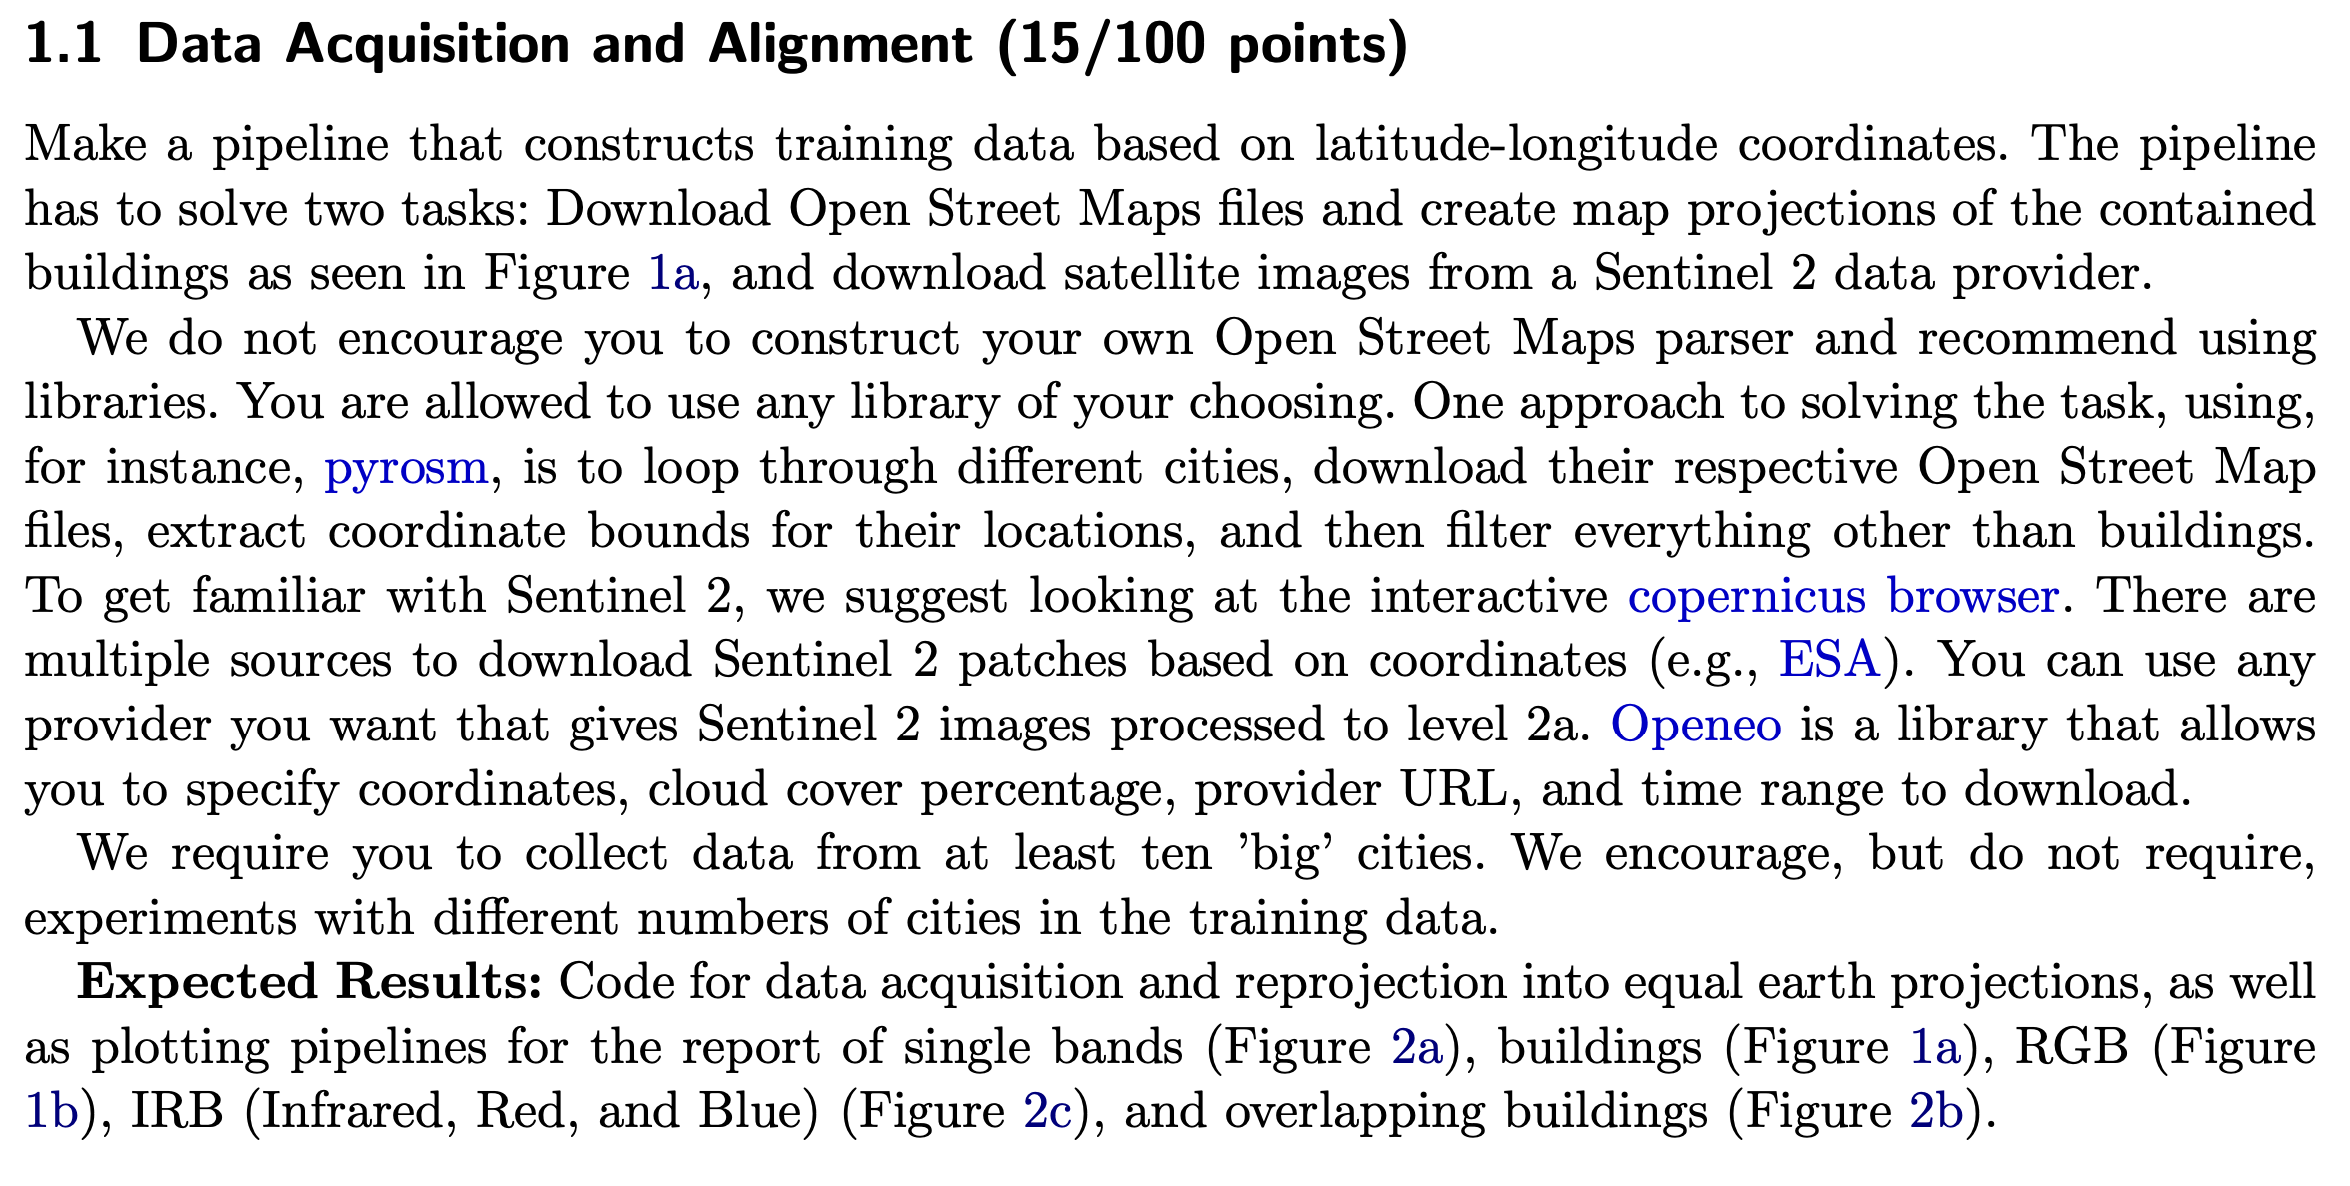

1. Data acquisition: Download the Open streetmaps files.

we could use pyrosm

In [1]:
import pyrosm
from pyrosm.data import sources
from io import BytesIO
import openeo

import xarray
import matplotlib.pyplot as plt
import numpy as np
import tempfile
import io

from pathlib import Path
from PIL import Image

In [88]:
# if devmode is true, then no files are downloaded and a local one will be used instead. 
# The showcases will not reflect the actual coordinate inputs obviously.
devmode = True
if devmode:
    print("YOU ARE RUNNING IN DEVMODE," 
          + " WHICH ACCELLERATES EXECUTION, BUT GIVES WRONG RESULTS. USE ONLY FOR DEVELOPMENT PURPOSES.")
    
ressource_path = Path("ressources/")
dev_mode_osm_fp = Path("ressources/Berlin.osm.pbf")
output_path = Path("output/")

YOU ARE RUNNING IN DEVMODE, WHICH ACCELLERATES EXECUTION, BUT GIVES WRONG RESULTS. USE ONLY FOR DEVELOPMENT PURPOSES.


In [74]:
# W, S, E, N
accuracy_test_coordinates = [13.294333, 52.454927, 13.500205, 52.574409]
bDomCoordinates = [13.399968, 52.518366, 13.402065, 52.519740]

# change these coordinates if you want to run the entire notebook for different coordinates.
demo_coordinates = accuracy_test_coordinates


rgb_bands = ["B04", "B03", "B02"]
ir_band = ["B08"]

all_bands = rgb_bands + ir_band

In [4]:
def get_city_data(city_name: str, save_locally = False):
    if devmode:
        fp = str(dev_mode_osm_fp)
    elif save_locally:
        fp = pyrosm.get_data(city_name, directory=ressource_path)
    else:
        fp = pyrosm.get_data(city_name)

    # only returning the fp, because if we convert to building we do not want to convert the entirety of the city.
    return fp
    

In [5]:
# List of cities
# TODO add more cities
# TODO go through at least 10 cities
available_cities = sources.cities.available

# Let's start with a single city at the beginning:
temp_city = "Berlin"

# set save_locally to true to save the pbf file to use the dev_mode accelleration.
city_data_fp = get_city_data(temp_city,save_locally=False)

print("city data saved at: ", city_data_fp)

city data saved at:  ressources/Berlin.osm.pbf


extracting buildings from a normal bounding box 
currently takes around 22 seconds. Be patient


b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x80\x00\x00\x01\xe0\x08\x06\x00\x00\x005\xd1\xdc\xe4\x00\x00\x009tEXtSoftware\x00Matplotlib version3.8.0, https://matplotlib.org/5\xb1\xb5\xab\x00\x00\x00\tpHYs\x00\x00\x0fa\x00\x00\x0fa\x01\xa8?\xa7i\x00\x00\x08\xc9IDATx\x9c\xed\xd61\x01\x00 \x0c\xc00\xc0\xbf\xe7\xe1\x02\x8e&\nzv\xcf\xcc\x02\x00\xa0\xe3\xfc\x0e\x00\x00\xe0-\x03\x08\x00\x10c\x00\x01\x00b\x0c \x00@\x8c\x01\x04\x00\x881\x80\x00\x001\x06\x10\x00 \xc6\x00\x02\x00\xc4\x18@\x00\x80\x18\x03\x08\x00\x10c\x00\x01\x00b\x0c \x00@\x8c\x01\x04\x00\x881\x80\x00\x001\x06\x10\x00 \xc6\x00\x02\x00\xc4\x18@\x00\x80\x18\x03\x08\x00\x10c\x00\x01\x00b\x0c \x00@\x8c\x01\x04\x00\x881\x80\x00\x001\x06\x10\x00 \xc6\x00\x02\x00\xc4\x18@\x00\x80\x18\x03\x08\x00\x10c\x00\x01\x00b\x0c \x00@\x8c\x01\x04\x00\x881\x80\x00\x001\x06\x10\x00 \xc6\x00\x02\x00\xc4\x18@\x00\x80\x18\x03\x08\x00\x10c\x00\x01\x00b\x0c \x00@\x8c\x01\x04\x00\x881\x80\x00\x001\x06\x10\x00 \xc6\x00\x02\x00\xc4\x18@\x00\x80\x18\x03

<Figure size 640x480 with 0 Axes>

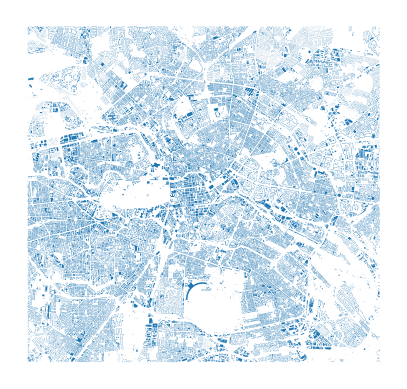

In [6]:
# TODO find a way to speed this up (devmode and otherwise)

def get_buildings_buffer(city_data_fp, bounding_box):
    osm = pyrosm.OSM(city_data_fp, bounding_box)
    print("extracting buildings from a normal bounding box \n"
          + "currently takes around 22 seconds. Be patient")
    buildings = osm.get_buildings()

    fig = plt.figure(frameon=False)
    buildings.plot()
    plt.axis('off')

    # Save to in-memory buffer
    file_buffer = BytesIO()

    # TODO what about the amount of pixels? image size? Check when we have the Neural Network.
    fig.savefig(file_buffer, format='png', bbox_inches='tight',transparent=True, pad_inches=0)

    return file_buffer

building_buffer = get_buildings_buffer(city_data_fp, demo_coordinates)
display(building_buffer.getvalue())
building_buffer.close()

Let's connect to copernicus, really not that hard leon

In [7]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")

# You will have to click on the displayed url in the output once first time you run the notebook
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

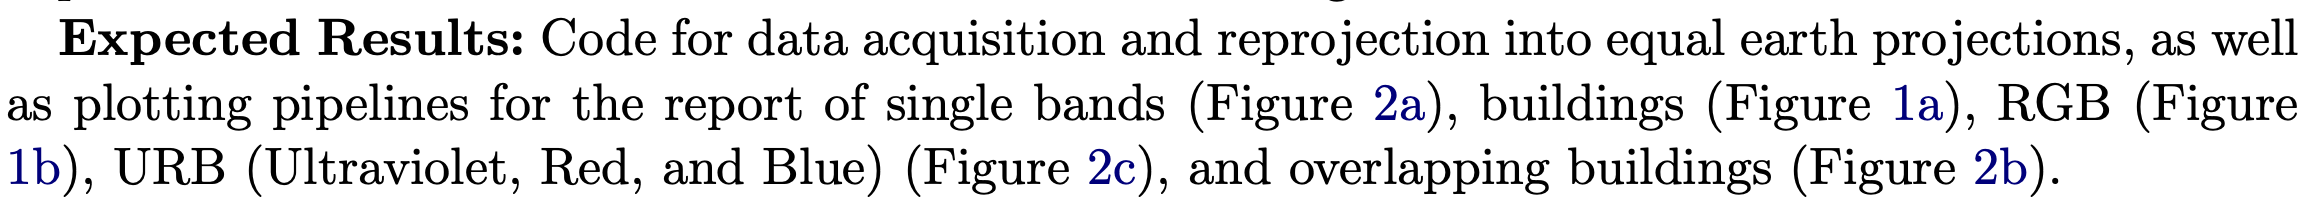

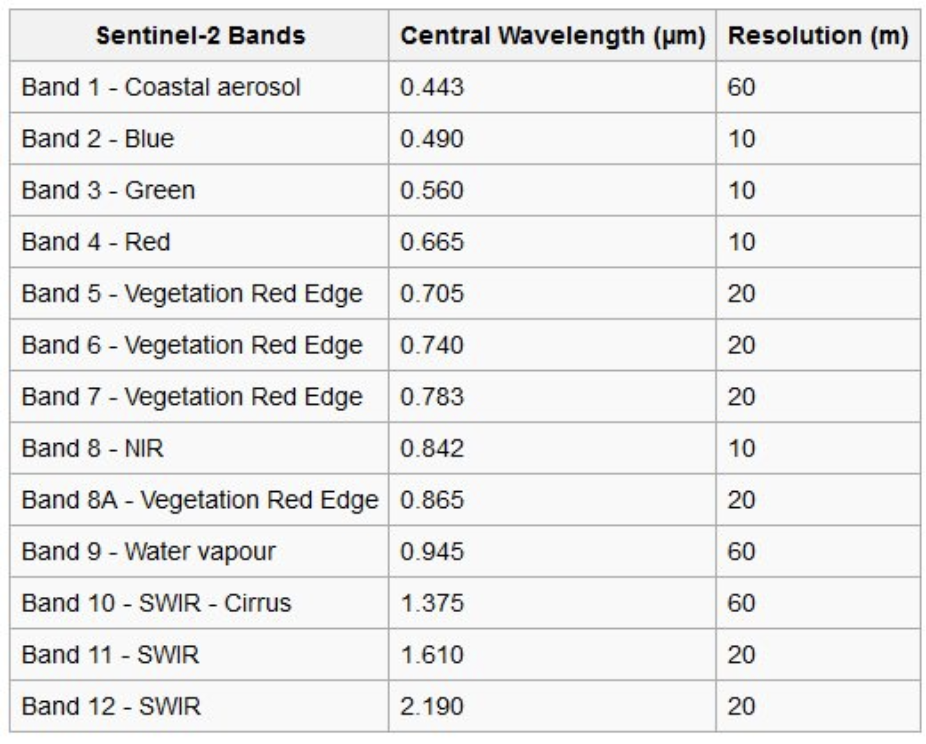

In [8]:
def get_spatial_extend(bounding_box):
    spatial_extend = {
    "west": bounding_box[0], 
    "south": bounding_box[1], 
    "east": bounding_box[2], 
    "north": bounding_box[3],
    }

    return spatial_extend

In [9]:
sentinel_2_connection_id = "SENTINEL2_L2A"

RGB_bands = ["B02", "B03", "B04"]
IR_Band = ["B08"]

dev_sat_img_fp = "output/composite_sattelite_image.nc"

In [85]:
# TODO Why do we need SCL???

def get_spatial_image(spatial_extend, bands, save_spatial_data = False):
    s2_cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=("2022-05-01", "2023-05-30"),
    spatial_extent=spatial_extend,
    bands=bands + ["SCL"],
    max_cloud_cover=20,
    )

    composite = s2_cube.mean_time()

    # use if you need the data locally for some reason.
    # choose enough bands.
    if save_spatial_data:
        print("downloading the spatial data and saving it locally.")
        composite.download(outputfile=dev_sat_img_fp)

    # Save to in-memory buffer
    with tempfile.NamedTemporaryFile(suffix=".nc") as tmpfile:
        if not devmode:
            print("downloading sattelite data. This may take a few minutes...")
            composite.download(outputfile=tmpfile.name)
            print("download finished")
        else:
            # Read the provided file if in dev mode
            with open(dev_sat_img_fp, "rb") as f:
                tmpfile.write(f.read())
                tmpfile.seek(0)

        # generate spatial image plot
        ds = xarray.load_dataset(tmpfile.name)
        # Convert xarray DataSet to a (bands, t, x, y) DataArray
        data = ds[bands].to_array(dim="bands")

        # handle single band images
        if len(bands) == 1:
            data = data.squeeze('bands')


        fig, ax = plt.subplots()
        plt.axis('off')
        plt.gca().xaxis.set_major_locator(plt.NullLocator())  # Removes padding
        plt.gca().yaxis.set_major_locator(plt.NullLocator())  # Removes padding
        data.plot.imshow(vmin=0, vmax=2000, ax=ax)

        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)

        plt.close(fig)
        # data.plot.imshow(vmin=0, vmax=2000)

        return buf

In [84]:
def display_sattelite_image(coordinates, bands, save_spatial_data = False):
    print("generating spacial image")
    satt_image_buf = get_spatial_image(get_spatial_extend(coordinates), bands = bands, save_spatial_data = save_spatial_data)
    sattelite_image = Image.open(io.BytesIO(satt_image_buf.getvalue()))
    display(sattelite_image)
    satt_image_buf.close()

generating spacial image
downloading sattelite data. This may take a few minutes...
download finished


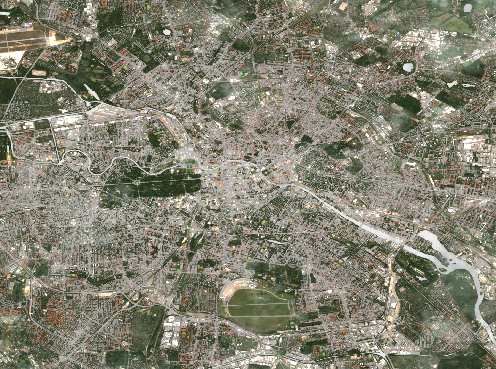

In [86]:
# RUN THIS ONCE WITH SAVE SPACIAL DATA = TRUE TO HAVE IT LOCALLY.
# display_sattelite_image(demo_coordinates, bands=all_bands, save_spatial_data = True)

RGB SATTELITE IMAGE

generating spacial image


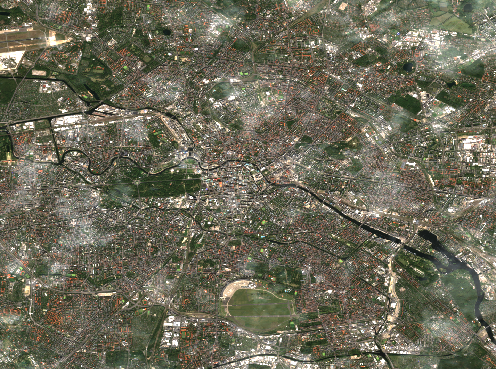

In [90]:
display_sattelite_image(demo_coordinates, bands=rgb_bands)

INFRARED SATTELITE IMAGE

generating spacial image


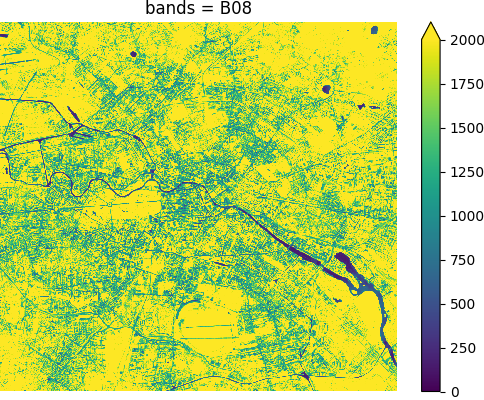

In [91]:
display_sattelite_image(demo_coordinates, bands=ir_band)

SINGLE BAND SATTELITE IMAGE

generating spacial image


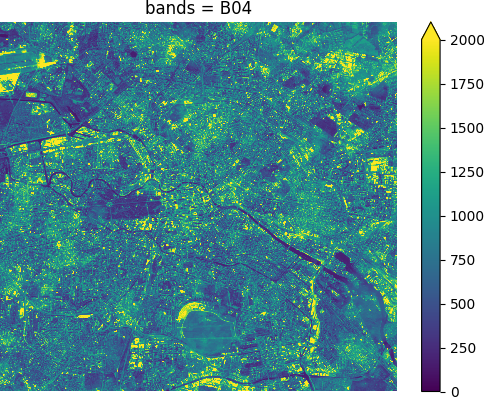

In [92]:
display_sattelite_image(demo_coordinates, bands=['B04'])

generating osm image
extracting buildings from a normal bounding box 
currently takes around 22 seconds. Be patient


b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x80\x00\x00\x01\xe0\x08\x06\x00\x00\x005\xd1\xdc\xe4\x00\x00\x009tEXtSoftware\x00Matplotlib version3.8.0, https://matplotlib.org/5\xb1\xb5\xab\x00\x00\x00\tpHYs\x00\x00\x0fa\x00\x00\x0fa\x01\xa8?\xa7i\x00\x00\x08\xc9IDATx\x9c\xed\xd61\x01\x00 \x0c\xc00\xc0\xbf\xe7\xe1\x02\x8e&\nzv\xcf\xcc\x02\x00\xa0\xe3\xfc\x0e\x00\x00\xe0-\x03\x08\x00\x10c\x00\x01\x00b\x0c \x00@\x8c\x01\x04\x00\x881\x80\x00\x001\x06\x10\x00 \xc6\x00\x02\x00\xc4\x18@\x00\x80\x18\x03\x08\x00\x10c\x00\x01\x00b\x0c \x00@\x8c\x01\x04\x00\x881\x80\x00\x001\x06\x10\x00 \xc6\x00\x02\x00\xc4\x18@\x00\x80\x18\x03\x08\x00\x10c\x00\x01\x00b\x0c \x00@\x8c\x01\x04\x00\x881\x80\x00\x001\x06\x10\x00 \xc6\x00\x02\x00\xc4\x18@\x00\x80\x18\x03\x08\x00\x10c\x00\x01\x00b\x0c \x00@\x8c\x01\x04\x00\x881\x80\x00\x001\x06\x10\x00 \xc6\x00\x02\x00\xc4\x18@\x00\x80\x18\x03\x08\x00\x10c\x00\x01\x00b\x0c \x00@\x8c\x01\x04\x00\x881\x80\x00\x001\x06\x10\x00 \xc6\x00\x02\x00\xc4\x18@\x00\x80\x18\x03

<Figure size 640x480 with 0 Axes>

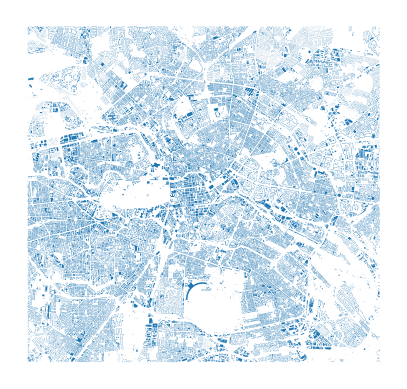

In [ ]:
print("generating osm image")
osm_buildings_buff = get_buildings_buffer(city_data_fp, demo_coordinates)
display(osm_buildings_buff.getvalue())
osm_buildings_buff.close()